In [18]:
import pandas as pd

In [19]:
df = pd.read_csv('transcription_fresh.csv')

In [20]:
df.head()

,medical_specialty,transcription
0,Orthopedic,"TITLE OF OPERATION: , Youngswick osteotomy wit..."
1,Orthopedic,"PREOPERATIVE DIAGNOSES:,1. Hallux rigidus, le..."
2,Orthopedic,"CHIEF COMPLAINT:, Left wrist pain.,HISTORY OF..."
3,Orthopedic,"PREOPERATIVE DIAGNOSIS: , Wrist ganglion.,POST..."
4,Orthopedic,"PREOPERATIVE DIAGNOSIS:, T11 compression frac..."


In [21]:
df = df.dropna(axis=0, subset=['transcription'])

In [22]:
df.medical_specialty.value_counts()

 Surgery                       664
 Consult - History and Phy.    465
 Cardiovascular / Pulmonary    318
 Orthopedic                    316
Name: medical_specialty, dtype: int64

In [23]:
df.transcription.isnull().value_counts()

False    1763
Name: transcription, dtype: int64

In [24]:
######### balancing dataset
balance_point = 316
def balance_dataset(df):
    df1 = df[df.medical_specialty == ' Consult - History and Phy.'].iloc[:balance_point]
    df2 = df[df.medical_specialty == ' Cardiovascular / Pulmonary'].iloc[:balance_point]
    df3 = df[df.medical_specialty == ' Orthopedic'].iloc[:balance_point]
    df4 = df[df.medical_specialty == ' Surgery'].iloc[:balance_point]
    
    frames = [df1, df2, df3, df4]
    return pd.concat(frames)

df = balance_dataset(df)

In [25]:
### shuffling the dataset
#from sklearn.utils import shuffle
#df = shuffle(df)
df = df.reset_index(drop=True)
df.head()

,medical_specialty,transcription
0,Consult - History and Phy.,"SUBJECTIVE:, The patient presents with Mom fo..."
1,Consult - History and Phy.,"CHIEF COMPLAINT:, Worker’s compensation injur..."
2,Consult - History and Phy.,"SUBJECTIVE:, Patient presents with Mom and Da..."
3,Consult - History and Phy.,"CHIEF COMPLAINT:, The patient comes for her w..."
4,Consult - History and Phy.,"TYPE OF CONSULTATION:, Wound care consult.,HI..."


In [26]:
df.shape

(1264, 2)

In [27]:
df.dtypes

medical_specialty    object
transcription        object
dtype: object

In [28]:
df['medical_specialty'] = df['medical_specialty'].astype('category')

In [29]:
df["medical_specialty_cat"] = df["medical_specialty"].cat.codes

In [30]:
messages = df.transcription.tolist()

In [31]:
########## finding map class to integer value #############
class0 = df[df.medical_specialty_cat == 0].iloc[0].medical_specialty
class1 = df[df.medical_specialty_cat == 1].iloc[0].medical_specialty
class2 = df[df.medical_specialty_cat == 2].iloc[0].medical_specialty
class3 = df[df.medical_specialty_cat == 3].iloc[0].medical_specialty
classes = {0 : class0, 1 : class1, 2 : class2, 3 : class3}

In [32]:
classes

{0: ' Cardiovascular / Pulmonary',
 1: ' Consult - History and Phy.',
 2: ' Orthopedic',
 3: ' Surgery'}

In [17]:
#Data cleaning and preprocessing
import re
import nltk
# nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
corpus = []

for i in range(0, len(messages)):
    message = re.sub('[^a-zA-Z]', ' ', str(messages[i]))
    message = message.lower()
    message = message.split()
    
    message = [lemmatizer.lemmatize(word) for word in message if not word in stopwords.words('english')]
    message = ' '.join(message)
    corpus.append(message)

In [18]:
# Creating the TF-IDF model
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(corpus)
X = vectorizer.transform(corpus).toarray()

In [19]:
X.shape

(1264, 14758)

In [20]:
y = df["medical_specialty"].cat.codes

In [21]:
# Train Test Split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [22]:
X_train.shape

(1011, 14758)

In [23]:
sm = SMOTE(random_state=2)
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

In [24]:
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)

print(np.asarray((unique, counts)).T)

[[  0 262]
 [  1 262]
 [  2 262]
 [  3 262]]


In [25]:
# Training model using Naive bayes classifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [26]:
################# NB Classifier
NB_model = MultinomialNB().fit(X_train, y_train)

In [27]:
naive_bayes_prediction = NB_model.predict(X_test)

In [28]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

print('naive_bayes accuracy: {}'.format(accuracy_score(y_test, naive_bayes_prediction)))

naive_bayes accuracy: 0.8221343873517787


In [29]:
naive_bayes_prediction

array([3, 1, 1, 1, 0, 3, 2, 2, 0, 1, 3, 3, 3, 1, 2, 3, 1, 2, 2, 1, 2, 0,
       1, 1, 0, 0, 0, 0, 2, 1, 1, 3, 1, 2, 2, 3, 1, 1, 3, 1, 2, 1, 3, 1,
       3, 0, 1, 1, 2, 1, 0, 2, 3, 0, 3, 0, 3, 3, 1, 1, 3, 0, 1, 2, 3, 3,
       3, 0, 2, 1, 3, 3, 1, 1, 3, 1, 1, 2, 0, 0, 3, 2, 3, 3, 2, 3, 1, 2,
       3, 1, 0, 0, 1, 1, 1, 0, 3, 2, 3, 0, 0, 2, 3, 2, 3, 2, 1, 0, 3, 0,
       3, 1, 1, 0, 1, 0, 2, 1, 3, 2, 0, 2, 1, 2, 3, 0, 0, 1, 3, 2, 1, 2,
       3, 1, 1, 1, 3, 0, 2, 3, 0, 3, 2, 0, 2, 3, 1, 1, 0, 2, 0, 1, 3, 0,
       0, 3, 3, 2, 0, 0, 1, 1, 1, 0, 1, 2, 1, 0, 2, 3, 0, 2, 2, 1, 0, 3,
       0, 0, 3, 1, 1, 3, 2, 3, 1, 3, 1, 1, 0, 1, 3, 3, 2, 2, 3, 1, 0, 2,
       1, 1, 2, 0, 2, 3, 1, 1, 3, 0, 2, 1, 3, 1, 1, 3, 1, 0, 1, 0, 0, 1,
       3, 1, 3, 3, 1, 0, 3, 1, 2, 1, 1, 0, 0, 2, 0, 1, 1, 1, 2, 3, 3, 0,
       1, 2, 0, 1, 1, 2, 1, 3, 0, 2, 1], dtype=int8)

In [30]:
################# SVC Classifier
SVC_model = SVC().fit(X_train, y_train)

In [31]:
SVC_prediction = SVC_model.predict(X_test)

In [32]:
SVC_prediction

array([3, 1, 2, 1, 0, 3, 2, 2, 0, 2, 3, 3, 3, 1, 2, 3, 1, 2, 3, 1, 2, 0,
       0, 1, 0, 0, 0, 0, 2, 1, 1, 3, 1, 2, 2, 3, 1, 1, 3, 1, 2, 1, 3, 1,
       3, 0, 1, 1, 2, 1, 0, 2, 3, 0, 3, 0, 3, 3, 2, 1, 3, 0, 1, 2, 3, 3,
       3, 0, 2, 1, 3, 3, 1, 1, 3, 1, 1, 2, 0, 0, 0, 2, 3, 3, 2, 3, 0, 2,
       3, 1, 0, 0, 1, 1, 1, 0, 3, 2, 3, 0, 0, 2, 3, 2, 3, 2, 1, 0, 3, 0,
       3, 1, 1, 0, 1, 0, 2, 2, 3, 2, 0, 2, 1, 2, 3, 0, 0, 0, 3, 2, 1, 2,
       3, 2, 1, 1, 3, 0, 2, 0, 0, 3, 2, 0, 3, 3, 1, 1, 0, 2, 0, 2, 3, 3,
       0, 0, 3, 2, 0, 0, 1, 1, 0, 0, 0, 3, 1, 0, 2, 3, 0, 2, 2, 1, 0, 3,
       0, 0, 3, 1, 1, 3, 2, 3, 1, 0, 1, 1, 0, 1, 3, 3, 2, 2, 3, 2, 0, 2,
       1, 1, 2, 0, 2, 3, 2, 1, 3, 0, 2, 1, 3, 1, 1, 3, 1, 0, 1, 0, 0, 1,
       3, 1, 3, 3, 1, 0, 3, 0, 2, 2, 1, 0, 0, 2, 0, 0, 0, 1, 2, 3, 0, 0,
       1, 2, 0, 0, 1, 2, 1, 3, 0, 2, 1], dtype=int8)

In [33]:
print('svc accuracy: {}'.format(accuracy_score(y_test, SVC_prediction)))

svc accuracy: 0.9051383399209486


In [34]:
import skopt
print('skopt %s' % skopt.__version__)

skopt 0.8.1


In [35]:

from numpy import mean
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from skopt.space import Integer
from skopt.space import Real
from skopt.space import Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt import BayesSearchCV

# define the space of hyperparameters to search
params = dict()
params['C'] = (1e-6, 100.0, 'log-uniform')
params['gamma'] = (1e-6, 100.0, 'log-uniform')
params['degree'] = (1,5)
params['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']


In [36]:

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the search
search = BayesSearchCV(estimator=SVC(), search_spaces=params, n_jobs=-1, cv=cv)

In [37]:
'''
# perform the search
search.fit(X_train, y_train)
# report the best result
print(search.best_score_)
print(search.best_params_)
'''

'\n# perform the search\nsearch.fit(X_train, y_train)\n# report the best result\nprint(search.best_score_)\nprint(search.best_params_)\n'

In [38]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,x_label,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=10, rotation = 90)
    plt.yticks(tick_marks, classes, fontsize=10)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=12)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel(x_label, fontsize=20)

    return plt

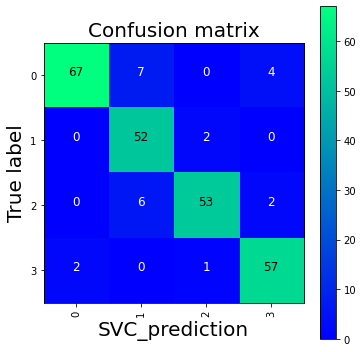

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from itertools import combinations
from sklearn.metrics import recall_score, confusion_matrix

cm = confusion_matrix(y_test, SVC_prediction)
fig = plt.figure(figsize=(5, 5))
plot = plot_confusion_matrix(cm, classes=classes,x_label = "SVC_prediction",normalize=False, 
                             title='Confusion matrix')
plt.show()

In [72]:
################# KNN Classifier
KNN_model = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

In [73]:
KNN_prediction = KNN_model.predict(X_test)

In [74]:
KNN_prediction

array([0, 0, 2, 1, 0, 3, 2, 2, 0, 0, 0, 3, 0, 0, 2, 0, 1, 2, 3, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 2, 3, 2, 1, 3, 0, 2, 0, 3, 0,
       3, 0, 0, 0, 2, 2, 0, 0, 3, 0, 3, 0, 3, 3, 2, 0, 3, 0, 1, 2, 3, 3,
       3, 0, 2, 0, 3, 3, 1, 1, 3, 0, 0, 2, 0, 0, 0, 2, 3, 2, 2, 3, 0, 2,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 3, 0, 0, 2, 3, 2, 3, 2, 0, 0, 3, 0,
       3, 1, 0, 0, 1, 0, 2, 1, 3, 0, 0, 2, 0, 2, 3, 0, 0, 0, 0, 2, 1, 2,
       3, 2, 1, 1, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 1, 0, 2, 0, 2, 3, 0,
       0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0,
       0, 0, 3, 2, 1, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 0, 0, 2,
       0, 0, 2, 0, 2, 3, 2, 1, 3, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 0, 0, 3, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 2, 0, 0, 0, 2, 1, 3, 0, 2, 0], dtype=int8)

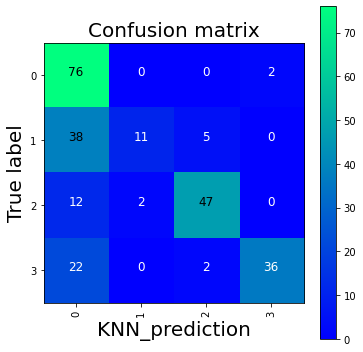

In [43]:
cm = confusion_matrix(y_test, KNN_prediction)
fig = plt.figure(figsize=(5, 5))
plot = plot_confusion_matrix(cm, classes=classes,x_label = "KNN_prediction",normalize=False, 
                             title='Confusion matrix')
plt.show()

In [44]:
################# DecisionTree Classifier
DecisionTree_model = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)

In [45]:
decisionTree_prediction = DecisionTree_model.predict(X_test)

In [46]:
decisionTree_prediction

array([3, 1, 1, 1, 0, 3, 2, 2, 2, 3, 3, 0, 3, 1, 2, 3, 0, 2, 2, 1, 2, 2,
       0, 1, 0, 0, 0, 0, 3, 1, 0, 3, 1, 3, 2, 3, 0, 1, 0, 1, 2, 1, 3, 1,
       3, 0, 1, 1, 2, 1, 2, 2, 3, 0, 2, 0, 3, 3, 0, 2, 3, 0, 1, 2, 3, 3,
       3, 0, 2, 2, 3, 3, 1, 1, 3, 0, 2, 2, 0, 1, 3, 2, 3, 3, 2, 3, 1, 2,
       3, 1, 2, 0, 2, 2, 1, 0, 3, 2, 3, 3, 0, 2, 3, 2, 3, 2, 1, 0, 3, 0,
       3, 1, 1, 0, 1, 3, 2, 1, 3, 2, 0, 2, 1, 2, 2, 0, 0, 1, 0, 2, 1, 2,
       3, 2, 0, 1, 0, 0, 3, 3, 0, 3, 2, 0, 2, 0, 1, 1, 0, 3, 3, 1, 2, 3,
       0, 3, 3, 2, 0, 0, 1, 1, 0, 0, 1, 2, 1, 0, 3, 3, 1, 2, 0, 0, 3, 0,
       0, 0, 3, 2, 1, 3, 3, 3, 0, 0, 1, 1, 0, 1, 3, 3, 2, 2, 3, 1, 3, 0,
       1, 1, 3, 0, 2, 3, 2, 2, 3, 0, 2, 1, 2, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 3, 3, 1, 0, 0, 0, 2, 1, 1, 3, 0, 2, 0, 1, 0, 1, 3, 3, 0, 0,
       1, 2, 0, 0, 0, 2, 1, 0, 0, 2, 1], dtype=int8)

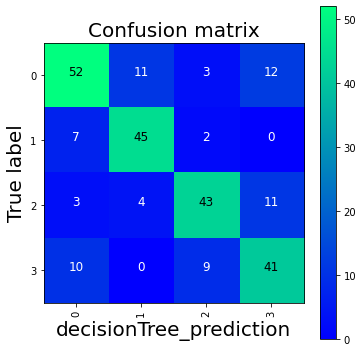

In [47]:
cm = confusion_matrix(y_test, decisionTree_prediction)
fig = plt.figure(figsize=(5, 5))
plot = plot_confusion_matrix(cm, classes=classes,x_label = "decisionTree_prediction",normalize=False, 
                             title='Confusion matrix')
plt.show()

In [48]:
################# Random forest Classifier
RandomForest_model=RandomForestClassifier(n_estimators=100).fit(X_train,y_train)

In [49]:
random_forest_prediction=RandomForest_model.predict(X_test)

In [50]:
random_forest_prediction

array([3, 1, 2, 1, 0, 3, 2, 2, 3, 1, 3, 3, 3, 1, 2, 3, 1, 2, 3, 1, 2, 0,
       0, 1, 0, 0, 0, 0, 2, 1, 1, 3, 1, 2, 2, 3, 1, 1, 3, 1, 2, 1, 3, 1,
       3, 0, 1, 1, 2, 1, 0, 2, 3, 0, 3, 0, 3, 3, 2, 1, 3, 0, 1, 2, 3, 3,
       3, 0, 2, 1, 3, 3, 1, 1, 3, 1, 1, 2, 0, 0, 0, 2, 3, 3, 2, 3, 1, 3,
       3, 1, 3, 0, 2, 1, 1, 0, 3, 2, 3, 0, 0, 2, 3, 2, 3, 2, 1, 0, 3, 0,
       3, 1, 1, 0, 1, 0, 2, 1, 3, 2, 0, 2, 1, 2, 3, 0, 0, 1, 3, 2, 1, 2,
       3, 1, 1, 1, 3, 0, 2, 3, 0, 3, 2, 0, 3, 3, 1, 1, 0, 3, 0, 1, 3, 3,
       0, 3, 3, 2, 0, 0, 1, 1, 0, 0, 0, 3, 1, 0, 2, 3, 0, 2, 2, 1, 0, 3,
       0, 0, 3, 1, 1, 3, 2, 3, 1, 0, 1, 1, 0, 1, 3, 3, 2, 2, 3, 1, 0, 2,
       1, 1, 2, 0, 2, 3, 1, 1, 3, 1, 2, 1, 3, 1, 1, 3, 1, 0, 1, 0, 0, 1,
       3, 1, 3, 3, 1, 0, 3, 0, 2, 2, 1, 3, 0, 2, 0, 1, 1, 1, 3, 3, 3, 0,
       1, 2, 0, 0, 2, 2, 1, 3, 0, 2, 1], dtype=int8)

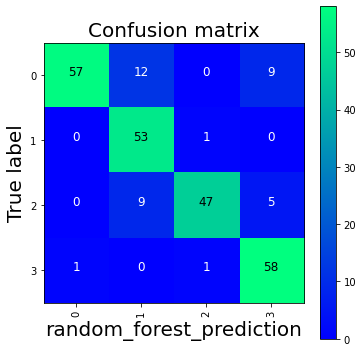

In [51]:
cm = confusion_matrix(y_test, random_forest_prediction)
fig = plt.figure(figsize=(5, 5))
plot = plot_confusion_matrix(cm, classes=classes,x_label = "random_forest_prediction",normalize=False, 
                             title='Confusion matrix')
plt.show()

In [52]:
#################LogisticRegression Classifier
LogisticRegression_model = LogisticRegression(solver='liblinear', C=10.0, random_state=0).fit(X_train,y_train)

In [53]:
LogisticRegression_prediction = LogisticRegression_model.predict(X_test)

In [54]:
LogisticRegression_prediction

array([3, 1, 2, 1, 0, 3, 2, 2, 0, 2, 3, 3, 3, 1, 2, 3, 1, 2, 3, 1, 2, 0,
       0, 1, 0, 0, 0, 0, 2, 1, 1, 3, 1, 2, 2, 3, 1, 1, 3, 1, 2, 1, 3, 1,
       3, 0, 1, 1, 2, 1, 0, 2, 3, 0, 3, 0, 3, 3, 2, 1, 3, 0, 1, 2, 3, 3,
       3, 0, 2, 1, 3, 3, 1, 1, 3, 1, 1, 2, 0, 0, 0, 2, 3, 3, 2, 3, 0, 2,
       3, 1, 0, 0, 2, 1, 1, 0, 3, 2, 3, 0, 0, 2, 3, 2, 3, 2, 1, 0, 3, 0,
       3, 1, 2, 2, 1, 0, 2, 2, 3, 2, 0, 2, 1, 2, 3, 0, 0, 0, 3, 2, 1, 2,
       3, 2, 1, 1, 3, 0, 2, 0, 0, 3, 2, 0, 3, 3, 1, 1, 0, 2, 0, 2, 3, 0,
       0, 0, 3, 2, 0, 0, 1, 1, 0, 0, 0, 3, 1, 0, 2, 3, 0, 2, 2, 1, 0, 3,
       0, 0, 3, 2, 1, 3, 2, 3, 1, 0, 1, 1, 0, 1, 3, 3, 2, 2, 3, 2, 0, 2,
       1, 1, 2, 0, 2, 3, 2, 1, 3, 0, 2, 1, 3, 1, 1, 3, 0, 0, 1, 0, 0, 1,
       3, 1, 3, 3, 1, 0, 3, 0, 2, 2, 1, 0, 0, 2, 0, 0, 0, 0, 2, 3, 0, 0,
       1, 2, 0, 0, 1, 2, 1, 3, 0, 2, 1], dtype=int8)

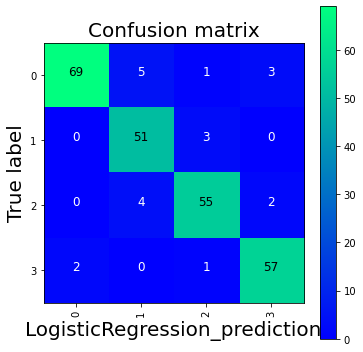

In [55]:
cm = confusion_matrix(y_test, LogisticRegression_prediction)
fig = plt.figure(figsize=(5, 5))
plot = plot_confusion_matrix(cm, classes=classes,x_label = "LogisticRegression_prediction",normalize=False, 
                             title='Confusion matrix')
plt.show()

In [56]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

print('naive_bayes f1_score: {}'.format(f1_score(y_test,naive_bayes_prediction, average='macro')))
print('KNN f1_score: {}'.format(f1_score(y_test,KNN_prediction, average='macro')))
print('SVC f1_score: {}'.format(f1_score(y_test,SVC_prediction, average='macro')))
print('Decision tree f1_score: {}'.format(f1_score(y_test,decisionTree_prediction, average='macro')))
print('Random_forest f1_score: {}'.format(f1_score(y_test,random_forest_prediction, average='macro')))
print('LogisticRegression f1_score: {}'.format(f1_score(y_test,LogisticRegression_prediction, average='macro')))

naive_bayes f1_score: 0.823521971975314
KNN f1_score: 0.6382524406338715
SVC f1_score: 0.9045815949894654
Decision tree f1_score: 0.7182277248616346
Random_forest f1_score: 0.8499234068627451
LogisticRegression f1_score: 0.916107119337166


In [75]:
print('naive_bayes accuracy: {}'.format(accuracy_score(y_test, naive_bayes_prediction)))
print('KNN accuracy: {}'.format(accuracy_score(y_test, KNN_prediction)))
print('SVC accuracy: {}'.format(accuracy_score(y_test, SVC_prediction)))
print('DecisionTree accuracy: {}'.format(accuracy_score(y_test, decisionTree_prediction)))
print('Random_forest accuracy: {}'.format(accuracy_score(y_test, random_forest_prediction)))
print('LogisticRegression accuracy: {}'.format(accuracy_score(y_test, LogisticRegression_prediction)))

naive_bayes accuracy: 0.8221343873517787
KNN accuracy: 0.7035573122529645
SVC accuracy: 0.9051383399209486
DecisionTree accuracy: 0.7154150197628458
Random_forest accuracy: 0.849802371541502
LogisticRegression accuracy: 0.9169960474308301


In [76]:
print('naive_bayes recall_score: {}'.format(recall_score(y_test,naive_bayes_prediction, average='macro')))
print('KNN recall_score: {}'.format(recall_score(y_test,KNN_prediction, average='macro')))
print('SVC recall_score: {}'.format(recall_score(y_test,SVC_prediction, average='macro')))
print('Decision tree recall_score: {}'.format(recall_score(y_test,decisionTree_prediction, average='macro')))
print('Random_forest recall_score: {}'.format(recall_score(y_test,random_forest_prediction, average='macro')))
print('LogisticRegression recall_score: {}'.format(recall_score(y_test,LogisticRegression_prediction, average='macro')))

naive_bayes recall_score: 0.8366015132408574
KNN recall_score: 0.6727184624725608
SVC recall_score: 0.9101974452384287
Decision tree recall_score: 0.7220628415300547
Random_forest recall_score: 0.8623522955490168
LogisticRegression recall_score: 0.9201747933305311


In [77]:
print('naive_bayes precision_score: {}'.format(precision_score(y_test,naive_bayes_prediction, average='macro')))
print('KNN precision_score: {}'.format(precision_score(y_test,KNN_prediction, average='macro')))
print('SVC precision_score: {}'.format(precision_score(y_test,SVC_prediction, average='macro')))
print('Decision tree precision_score: {}'.format(precision_score(y_test,decisionTree_prediction, average='macro')))
print('Random_forest precision_score: {}'.format(precision_score(y_test,random_forest_prediction, average='macro')))
print('LogisticRegression precision_score: {}'.format(precision_score(y_test,LogisticRegression_prediction, average='macro')))

naive_bayes precision_score: 0.8446595309810672
KNN precision_score: 0.8199401334632532
SVC precision_score: 0.9055512422360249
Decision tree precision_score: 0.7168082967836258
Random_forest precision_score: 0.8659285164827037
LogisticRegression precision_score: 0.9144631228229593


In [60]:
confusion_matrix(y_test, naive_bayes_prediction)

array([[54, 16,  0,  8],
       [ 0, 54,  0,  0],
       [ 0, 13, 46,  2],
       [ 2,  0,  4, 54]])

In [61]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()

In [62]:
model.fit(X_train, y_train)

GradientBoostingClassifier()

In [63]:
GBC_prediction = model.predict(X_test)

In [64]:
print('GradientBoostingClassifier f1_score: {}'.format(f1_score(y_test,GBC_prediction, average='macro')))

GradientBoostingClassifier f1_score: 0.8651601979128112


In [65]:
print('GradientBoostingClassifier accuracy: {}'.format(accuracy_score(y_test, GBC_prediction)))

GradientBoostingClassifier accuracy: 0.8656126482213439


In [66]:
from xgboost import XGBClassifier

In [67]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [68]:
XGB_prediction = model.predict(X_test)

In [69]:
print('XGBClassifier f1_score: {}'.format(f1_score(y_test,XGB_prediction, average='macro')))
print('XGBClassifier accuracy: {}'.format(accuracy_score(y_test, GBC_prediction)))

XGBClassifier f1_score: 0.8408380397746624
XGBClassifier accuracy: 0.8656126482213439


In [70]:
import pickle
pickle_out = open("models/KNN_model.pkl","wb")
pickle.dump(KNN_model, pickle_out)
pickle_out.close()

In [71]:
import pickle
# saving models
with open('models/NB_model.pickle', 'wb') as NB_modelhandle:
    pickle.dump(NB_model, NB_modelhandle, protocol=pickle.HIGHEST_PROTOCOL)
    NB_modelhandle.close()

with open('models/SVC_model.pickle', 'wb') as SVC_modelhandle:
    pickle.dump(SVC_model, SVC_modelhandle, protocol=pickle.HIGHEST_PROTOCOL)
    SVC_modelhandle.close()
    
with open('models/KNN_model.pickle', 'wb') as KNN_modelhandle:
    pickle.dump(KNN_model, KNN_modelhandle, protocol=pickle.HIGHEST_PROTOCOL)
    KNN_modelhandle.close()
    
with open('models/DecisionTree_model.pickle', 'wb') as DecisionTree_modelhandle:
    pickle.dump(DecisionTree_model, DecisionTree_modelhandle, protocol=pickle.HIGHEST_PROTOCOL)
    DecisionTree_modelhandle.close()
    
with open('models/RandomForest_model.pickle', 'wb') as RandomForest_modelhandle:
    pickle.dump(RandomForest_model, RandomForest_modelhandle, protocol=pickle.HIGHEST_PROTOCOL)
    RandomForest_modelhandle.close()
    
with open('models/LogisticRegression_model.pickle', 'wb') as LogisticRegression_modelhandle:
    pickle.dump(LogisticRegression_model, LogisticRegression_modelhandle, protocol=pickle.HIGHEST_PROTOCOL)
    LogisticRegression_modelhandle.close()
    
with open('models/vectorizer.pickle', 'wb') as vectorizerhandle:
    pickle.dump(vectorizer, vectorizerhandle, protocol=pickle.HIGHEST_PROTOCOL)
    vectorizerhandle.close()


In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer
# list of text documents
text = ["The quick brown fox jumped over the lazy dog.",
		"The dog.",
		"The fox"]
test_text = 'the fox is bad'
vectorizer = TfidfVectorizer()
vectorizer.fit(text)

# encode document
vector = vectorizer.transform([test_text])
# summarize encoded vector
print(vector.shape)
print(vector.toarray())

(1, 8)
[[0.         0.         0.78980693 0.         0.         0.
  0.         0.61335554]]


In [170]:
with open('models/vectorizer.pickle', 'rb') as vectorizerhandle:
    classical_vectorizer = pickle.load(vectorizerhandle)
    vectorizerhandle.close()

In [172]:
vectorizer.transform([corpus[0]]).toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [57]:
max_index

0